In [1]:
#import libraries

import pandas as pd
import datetime as dt
from datetime import datetime
import yfinance as yf
import os
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import chow_test
import numpy as np
import sklearn
from scipy import stats
from statsmodels.stats.stattools import jarque_bera
from johansen_test import coint_johansen
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima import auto_arima

In [2]:
# Downloading SPDR S&P 500 ETF Trust (SPY) stock data from yahoo finance

# Check if the S&P 500 stock data exit
if not os.path.exists('stockdata/SPY.csv'):
    
# Set start and end date parameters     
    startDate = dt.datetime(2015,1,1)
    endDate = dt.datetime(2019,12,31)

# get the S&P 500 stock data
    spy_data = yf.download('SPY', startDate, endDate)
    
# make directory and store stock data    
    os.makedirs('stockdata')
    spy_data.to_csv('stockdata/SPY.csv')
else:
    pass

In [3]:
# Read SPDR S&P 500 (SPY) stock data
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
spy = pd.read_csv('./stockdata/SPY.csv', usecols=['Date','Adj Close'], 
                  parse_dates=['Date'], date_parser=dateparse)

In [4]:
# claculate log returns
spy['Log Returns'] = np.log(spy['Adj Close']/spy['Adj Close'].shift(1))

In [5]:
# Calculate mean and standard deviation on SPY Prices
print('No of observations :', len(spy))
spy[['Log Returns']].describe().loc[['mean','std']]

No of observations : 1257


,Log Returns
mean,0.000434
std,0.008476


In [6]:
# Implementing technical indicators 
# Calculation of Simple Moving average and EWMA using TA.Lib

spy['SMA_50'] = ta.SMA(spy['Adj Close'],50) # 50-day Simple Moving Average
spy['EMA_50'] = ta.EMA(spy['Adj Close'],50) # 50-day Exponential Weighted Moving Average
spy['EMA_200'] = ta.EMA(spy['Adj Close'],200) # 200-day Exponential Weighted Moving Average

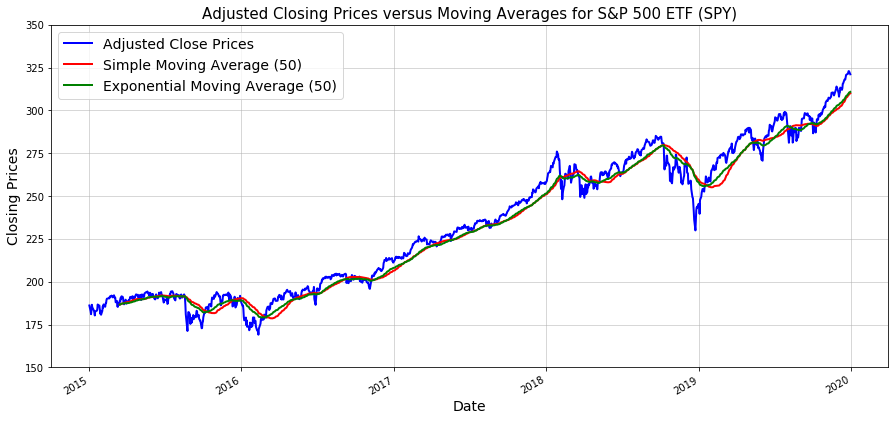

In [7]:
# Plotting Adjusted Closing Prices and Moving Averages
fig, ax = plt.subplots(figsize=(15,7))

spy.plot(x='Date', y='Adj Close', ax=ax, label = 'Adjusted Close Prices', lw=2, color='b')
spy.plot(x='Date', y='SMA_50', ax=ax, label = 'Simple Moving Average (50)', lw=2, color='r')
spy.plot(x='Date', y='EMA_50', ax=ax, label = 'Exponential Moving Average (50)', lw=2, color='g')

plt.ylim([150,350])
#plt.xlim(['2014-12-31', '2020-1-1'])
plt.legend(loc=2,prop={'size':14})
ax.grid(linewidth=0.5)
ax.set_xlabel("Date",{'fontsize':14})
ax.set_ylabel("Closing Prices",{'fontsize':14})
ax.set_title("Adjusted Closing Prices versus Moving Averages for S&P 500 ETF (SPY)",{'fontsize':15})
plt.show()

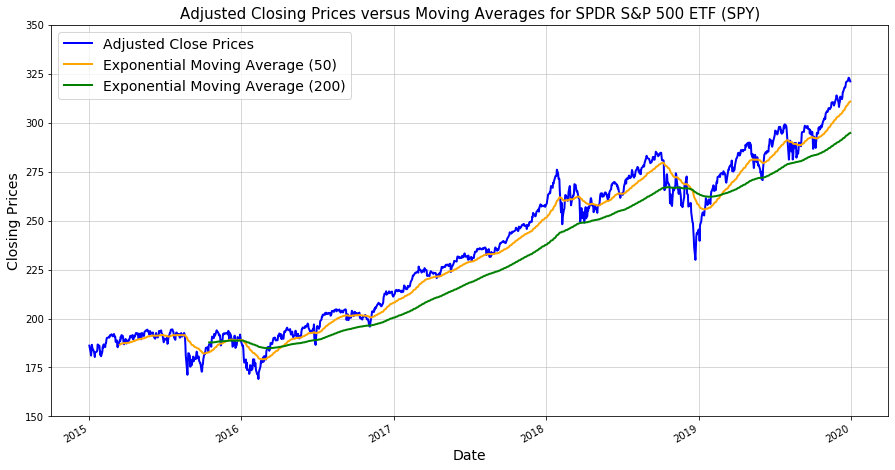

In [8]:
# Plotting Adjusted Closing Prices and Moving Averages

fig, ax = plt.subplots(figsize=(15,8))

spy.plot(x='Date', y='Adj Close', ax=ax, label = 'Adjusted Close Prices', lw=2, color='b')
spy.plot(x='Date', y='EMA_50', ax=ax, label = 'Exponential Moving Average (50)', lw=2, color='orange')
spy.plot(x='Date', y='EMA_200', ax=ax, label = 'Exponential Moving Average (200)', lw=2, color='g')

plt.ylim([150,350])
#plt.xlim(['2014-12-31', '2020-1-1'])
plt.legend(loc=2,prop={'size':14})
ax.grid(linewidth=0.5)
ax.set_xlabel("Date",{'fontsize':14})
ax.set_ylabel("Closing Prices",{'fontsize':14})
ax.set_title("Adjusted Closing Prices versus Moving Averages for SPDR S&P 500 ETF (SPY)",{'fontsize':15})
plt.show()

In [9]:
# Identifying structural breaks using Chow-Test
# read SPY data
spy_ct = spy
spy_ct.fillna(0, inplace = True)

# Set Parameters
y1 = spy_ct[spy_ct['Date'] < dt.datetime(2017,7,1)]['Adj Close'] # grp 1 
x1 = spy_ct[spy_ct['Date'] < dt.datetime(2017,7,1)]['EMA_50'] # EMA grp 1
y2 = spy_ct[spy_ct['Date'] >= dt.datetime(2017,7,1)]['Adj Close'] # grp 2
x2 = spy_ct[spy_ct['Date'] >= dt.datetime(2017,7,1)]['EMA_50'] # EMA grp 2

# Apply Chow tests
f_test = chow_test.f_value(y1, x1, y2, x2)
p_val = chow_test.p_value(y1, x1, y2, x2)

# Print results
print('Results of Chow Test: ')
print('---------------------------')
print("F_Test: " ,f_test[0])
print("p_value: " , p_val)

Results of Chow Test: 
---------------------------
F_Test:  2608.040019158473
p_value:  0.0


In [10]:
# Applying Bera-Jarque test for returns

#Apply JB test on log returns
jb_test = jarque_bera(spy['Log Returns'].dropna())

# Print results
print('Results of Jarque-Bera Test: ')
print('------------------------------------')
print('Test statistics: ',jb_test[0])
print('p_value is: ', jb_test[1])
print('Skewness: ',jb_test[2])
print('Kurtosis: ', jb_test[3])

Results of Jarque-Bera Test: 
------------------------------------
Test statistics:  893.9575176986248
p_value is:  7.57864394464457e-195
Skewness:  -0.5414347900876193
Kurtosis:  6.986953067808333


In [11]:
# Apply a cointegration test

# Read SPY data: Adj_Close, EMA_50, and EMA_200
spy_df = spy[['Adj Close', 'EMA_50', 'EMA_200']]

# Run Johansen test 
print('Results of Johansen Cointegration Test: ')
coint_johansen(spy_df, 0, 1)

Results of Johansen Cointegration Test: 
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 33.4552 27.0669 29.7961 35.4628
r = 1 	 7.3278 13.4294 15.4943 19.9349
r = 2 	 0.1435 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.1274 18.8928 21.1314 25.865
r = 1 	 7.1843 12.2971 14.2639 18.52
r = 2 	 0.1435 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.02950595 -0.00714048 -0.03328734]
 [-0.02855883 -0.01234831 -0.00068111]
 [ 0.00041836  0.01752054  0.00633943]]
--------------------------------------------------
eigenvalues:
 [0.02060342 0.0057082  0.0001143 ]
--------------------------------------------------


In [12]:
# Forecast next period (t+1) asset return evolution using AR(1) model
# Read data
spy_ds = spy.set_index('Date')
spy_rb = spy_ds['Adj Close'].resample('B').bfill().dropna()

# Build Seasonal auto-ARIMA model
spy_rb_smodel = pm.auto_arima(spy_rb, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
#Print results
spy_rb_smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=5413.955, BIC=5439.767, Time=7.989 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=8325.549, BIC=8335.874, Time=0.095 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=5874.911, BIC=5895.561, Time=1.749 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=7144.336, BIC=7164.985, Time=1.945 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=8378.731, BIC=8383.893, Time=0.059 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=6215.209, BIC=6235.859, Time=0.463 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=5415.936, BIC=5446.910, Time=5.485 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 0, 1)x(0, 1, 2, 12) (constant=True); AIC=5415.726, BIC=5446.700, Time=23.084 seconds
Near

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1302
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2696.679
Date:                              Tue, 25 Feb 2020   AIC                           5407.357
Time:                                      19:48:49   BIC                           5443.494
Sample:                                           0   HQIC                          5420.921
                                             - 1302                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0203      0.008      2.476      0.013       0.004       0.036
ar.L1          0.4327      0.157      2.754      0.006       0.125       0.741
ar.L2          0.5509      0.155      3.562      0.000       0.248       0.854
ma.L1          0.5515      0.157      3.519      0.000       0.244       0.859
ma.L2         -0.0787      0.021     -3.758      0.000      -0.120      -0.038
ma.S.L12      -0.9970      0.047    -21.325      0.000      -1.089      -0.905
sigma2         3.6787      0.177     20.729      0.000       3.331       4.027
===================================================================================
Ljung-Box (Q):                       33.76   Jarque-Bera (JB):              1268.50
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

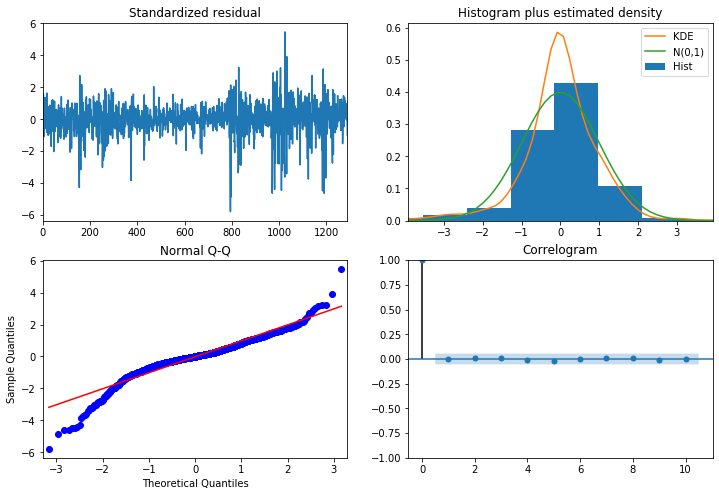

In [13]:
# Review residual plot generated by ARIMA model
spy_rb_smodel.plot_diagnostics(figsize=(12,8))
plt.show()

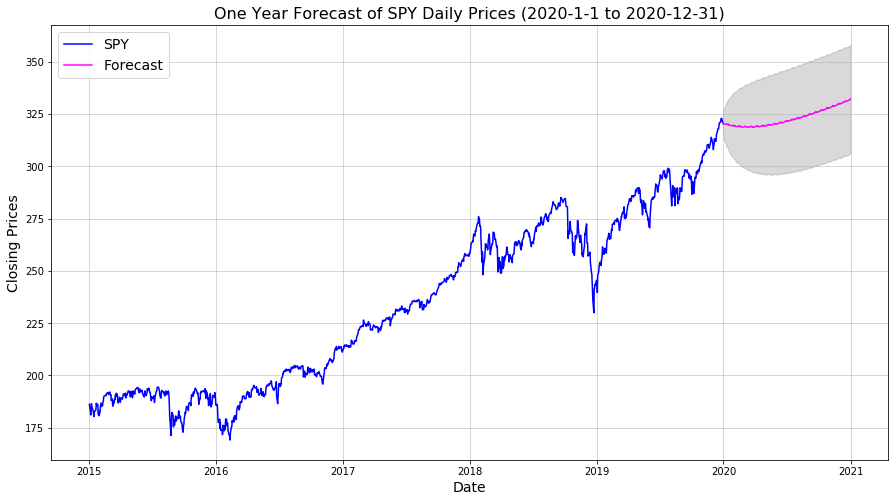

In [20]:
# Forecast and plot chart
n_periods = 264
fitted, confint = spy_rb_smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(spy_rb.index[-1], periods = n_periods, freq='B')


# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


# Plot
fig = plt.figure(figsize=(15,8))
plt.plot(spy_rb, label='SPY', color='blue')
plt.plot(fitted_series, color='magenta', label='Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.grid(linewidth=0.5)
plt.legend(loc=2,prop={'size':14})
plt.title("One Year Forecast of SPY Daily Prices (2020-1-1 to 2020-12-31)", {'fontsize':16})
plt.xlabel("Date",{'fontsize':14})
plt.ylabel("Closing Prices",{'fontsize':14})
plt.show()

In [ ]:
# claculate log returns
spy['Log Returns'] = np.log(spy['Adj Close']/spy['Adj Close'].shift(1))

# Implementing technical indicators 
# Calculation of Simple Moving average and EWMA using TA.Lib

spy['SMA_50'] = ta.SMA(spy['Adj Close'],50) # 50-day Simple Moving Average
spy['EMA_50'] = ta.EMA(spy['Adj Close'],50) # 50-day Exponential Weighted Moving Average
spy['EMA_200'] = ta.EMA(spy['Adj Close'],200) # 200-day Exponential Weighted Moving Average

spy.head()